## Introduction

From Kaggle:

<strong> Context </strong>

It is important that credit card companies are able to recognize fraudulent credit card transactions so that customers are not charged for items that they did not purchase.

<strong> Content </strong>

The dataset contains transactions made by credit cards in September 2013 by European cardholders.
This dataset presents transactions that occurred in two days, where we have 492 frauds out of 284,807 transactions. The dataset is highly unbalanced, the positive class (frauds) account for 0.172% of all transactions.

It contains only numerical input variables which are the result of a PCA transformation. Unfortunately, due to confidentiality issues, we cannot provide the original features and more background information about the data. Features V1, V2, … V28 are the principal components obtained with PCA, the only features which have not been transformed with PCA are 'Time' and 'Amount'. Feature 'Time' contains the seconds elapsed between each transaction and the first transaction in the dataset. The feature 'Amount' is the transaction Amount, this feature can be used for example-dependant cost-sensitive learning. Feature 'Class' is the response variable and it takes value 1 in case of fraud and 0 otherwise.

Given the class imbalance ratio, we recommend measuring the accuracy using the Area Under the Precision-Recall Curve (AUPRC). Confusion matrix accuracy is not meaningful for unbalanced classification.

## Required Packages

In [25]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.metrics import roc_auc_score
import lightgbm as lgb
from lightgbm import LGBMClassifier
from sklearn.metrics import confusion_matrix, precision_score, recall_score, roc_curve, precision_recall_curve, auc
import pickle
from sklearn.preprocessing import StandardScaler

## Importing Data

In [5]:
df_raw = pd.read_csv(r"C:\Users\bened\OneDrive\Data Science\credit-fraud\creditcard.csv")
df = df_raw

## Exploring our Data
Observations:
- Time is in seconds, totalling 2 days
- V1 to V28 are scaled values, anonymised for privacy -> we need to scale Time and Amount
- Class is a binary target
- No missing values
- Highly imbalanced dataset (492 Class = 1, 284315 Class = 0)
- No multicollinearity in our dataset
- Fraudulent transactions have a larger interquartile range but have way fewer outliers than honest transactions
- Fraudulent transactions do not have a clear behaviour. Honest transactions however, have a clear behaviour throughout the day, exhibiting seasonality.

In [6]:
# Glimpse of data
df.describe()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
count,284807.000000,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,...,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,284807.000000,284807.000000
mean,94813.859575,3.918649e-15,5.682686e-16,-8.761736e-15,2.811118e-15,-1.552103e-15,2.040130e-15,-1.698953e-15,-1.893285e-16,-3.147640e-15,...,1.473120e-16,8.042109e-16,5.282512e-16,4.456271e-15,1.426896e-15,1.701640e-15,-3.662252e-16,-1.217809e-16,88.349619,0.001727
std,47488.145955,1.958696e+00,1.651309e+00,1.516255e+00,1.415869e+00,1.380247e+00,1.332271e+00,1.237094e+00,1.194353e+00,1.098632e+00,...,7.345240e-01,7.257016e-01,6.244603e-01,6.056471e-01,5.212781e-01,4.822270e-01,4.036325e-01,3.300833e-01,250.120109,0.041527
min,0.000000,-5.640751e+01,-7.271573e+01,-4.832559e+01,-5.683171e+00,-1.137433e+02,-2.616051e+01,-4.355724e+01,-7.321672e+01,-1.343407e+01,...,-3.483038e+01,-1.093314e+01,-4.480774e+01,-2.836627e+00,-1.029540e+01,-2.604551e+00,-2.256568e+01,-1.543008e+01,0.000000,0.000000
25%,54201.500000,-9.203734e-01,-5.985499e-01,-8.903648e-01,-8.486401e-01,-6.915971e-01,-7.682956e-01,-5.540759e-01,-2.086297e-01,-6.430976e-01,...,-2.283949e-01,-5.423504e-01,-1.618463e-01,-3.545861e-01,-3.171451e-01,-3.269839e-01,-7.083953e-02,-5.295979e-02,5.600000,0.000000
50%,84692.000000,1.810880e-02,6.548556e-02,1.798463e-01,-1.984653e-02,-5.433583e-02,-2.741871e-01,4.010308e-02,2.235804e-02,-5.142873e-02,...,-2.945017e-02,6.781943e-03,-1.119293e-02,4.097606e-02,1.659350e-02,-5.213911e-02,1.342146e-03,1.124383e-02,22.000000,0.000000
75%,139320.500000,1.315642e+00,8.037239e-01,1.027196e+00,7.433413e-01,6.119264e-01,3.985649e-01,5.704361e-01,3.273459e-01,5.971390e-01,...,1.863772e-01,5.285536e-01,1.476421e-01,4.395266e-01,3.507156e-01,2.409522e-01,9.104512e-02,7.827995e-02,77.165000,0.000000
max,172792.000000,2.454930e+00,2.205773e+01,9.382558e+00,1.687534e+01,3.480167e+01,7.330163e+01,1.205895e+02,2.000721e+01,1.559499e+01,...,2.720284e+01,1.050309e+01,2.252841e+01,4.584549e+00,7.519589e+00,3.517346e+00,3.161220e+01,3.384781e+01,25691.160000,1.000000


In [7]:
# Col names
df.columns

Index(['Time', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10',
       'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20',
       'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'Amount',
       'Class'],
      dtype='object')

In [8]:
# Check for missing data
df.isnull().sum()

Time      0
V1        0
V2        0
V3        0
V4        0
V5        0
V6        0
V7        0
V8        0
V9        0
V10       0
V11       0
V12       0
V13       0
V14       0
V15       0
V16       0
V17       0
V18       0
V19       0
V20       0
V21       0
V22       0
V23       0
V24       0
V25       0
V26       0
V27       0
V28       0
Amount    0
Class     0
dtype: int64

In [9]:
# it is a classification problem - check if data target is imbalanced
print("Count of honest vs fraudulent transactions")
print(df.groupby('Class')['Class'].count())

print("Proportion of faudulent transactions:", 
      round(df.groupby('Class')['Class'].count()[1]/df.groupby('Class')['Class'].count()[0], 4))

Count of honest vs fraudulent transactions
Class
0    284315
1       492
Name: Class, dtype: int64
Proportion of faudulent transactions: 0.0017


In [10]:
df.head()
# Time - in seconds elapsed for 2 days
# V1-V28 are scaled values

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


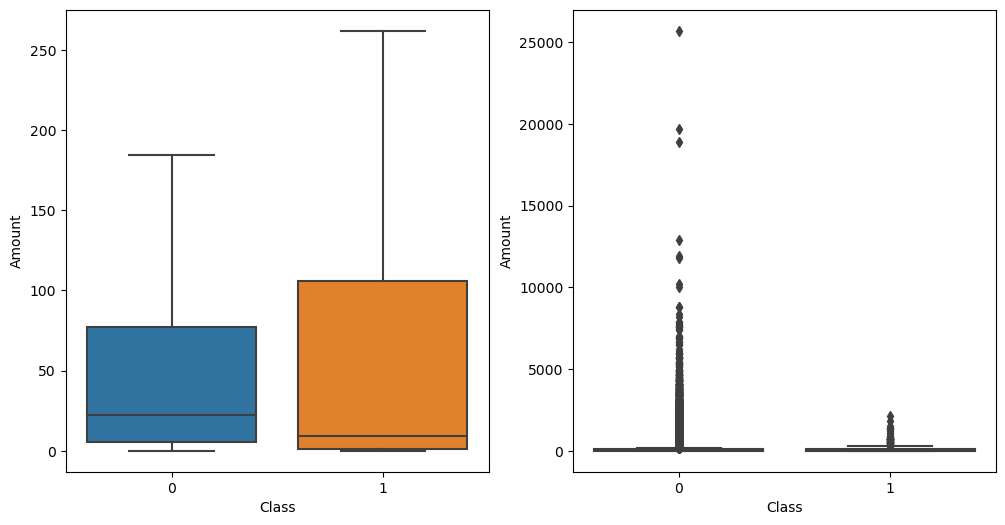

In [11]:
# Boxplot of Amount for Honest vs Fraud, excluding outliers
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(12,6))

s = sns.boxplot(ax=ax1, data=df, x='Class', y='Amount', showfliers=False)
s = sns.boxplot(ax=ax2, data=df, x='Class', y='Amount', showfliers=True)
plt.show()

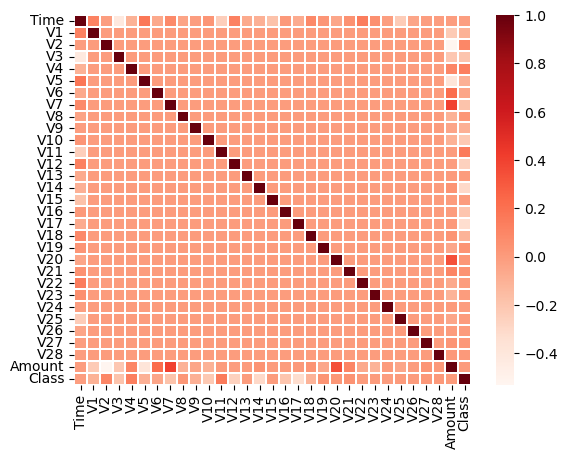

In [12]:
# Correlation Plot
corr = df.corr()
sns.heatmap(data=corr, xticklabels=corr.columns, yticklabels=corr.columns, linewidths=0.1, cmap='Reds')
plt.show()

In [13]:
df[df['Class'] == 1]

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
541,406.0,-2.312227,1.951992,-1.609851,3.997906,-0.522188,-1.426545,-2.537387,1.391657,-2.770089,...,0.517232,-0.035049,-0.465211,0.320198,0.044519,0.177840,0.261145,-0.143276,0.00,1
623,472.0,-3.043541,-3.157307,1.088463,2.288644,1.359805,-1.064823,0.325574,-0.067794,-0.270953,...,0.661696,0.435477,1.375966,-0.293803,0.279798,-0.145362,-0.252773,0.035764,529.00,1
4920,4462.0,-2.303350,1.759247,-0.359745,2.330243,-0.821628,-0.075788,0.562320,-0.399147,-0.238253,...,-0.294166,-0.932391,0.172726,-0.087330,-0.156114,-0.542628,0.039566,-0.153029,239.93,1
6108,6986.0,-4.397974,1.358367,-2.592844,2.679787,-1.128131,-1.706536,-3.496197,-0.248778,-0.247768,...,0.573574,0.176968,-0.436207,-0.053502,0.252405,-0.657488,-0.827136,0.849573,59.00,1
6329,7519.0,1.234235,3.019740,-4.304597,4.732795,3.624201,-1.357746,1.713445,-0.496358,-1.282858,...,-0.379068,-0.704181,-0.656805,-1.632653,1.488901,0.566797,-0.010016,0.146793,1.00,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
279863,169142.0,-1.927883,1.125653,-4.518331,1.749293,-1.566487,-2.010494,-0.882850,0.697211,-2.064945,...,0.778584,-0.319189,0.639419,-0.294885,0.537503,0.788395,0.292680,0.147968,390.00,1
280143,169347.0,1.378559,1.289381,-5.004247,1.411850,0.442581,-1.326536,-1.413170,0.248525,-1.127396,...,0.370612,0.028234,-0.145640,-0.081049,0.521875,0.739467,0.389152,0.186637,0.76,1
280149,169351.0,-0.676143,1.126366,-2.213700,0.468308,-1.120541,-0.003346,-2.234739,1.210158,-0.652250,...,0.751826,0.834108,0.190944,0.032070,-0.739695,0.471111,0.385107,0.194361,77.89,1
281144,169966.0,-3.113832,0.585864,-5.399730,1.817092,-0.840618,-2.943548,-2.208002,1.058733,-1.632333,...,0.583276,-0.269209,-0.456108,-0.183659,-0.328168,0.606116,0.884876,-0.253700,245.00,1


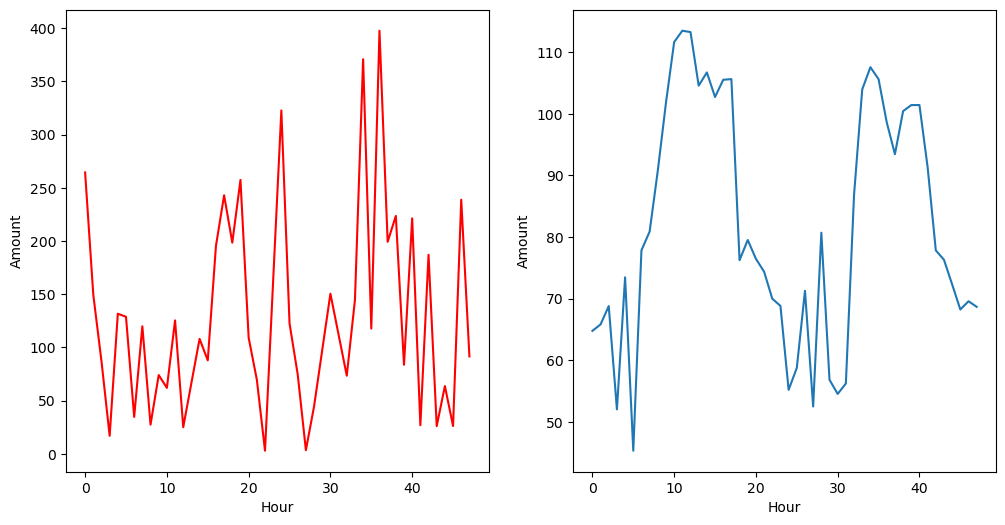

In [14]:
# Mean Transaction Amount over Hour by Class
df['Hour'] = df['Time'].apply(lambda x: np.floor(x/3600))
fig, (ax1,ax2) = plt.subplots(ncols=2, figsize=(12,6))
df_1 = df[df['Class'] == 1]
df_0 = df[df['Class'] == 0]


s = sns.lineplot(ax=ax1,data=df_1, x='Hour', y='Amount', color='Red', errorbar=None)
s = sns.lineplot(ax=ax2,data=df_0, x='Hour', y='Amount', errorbar=None)

plt.show()

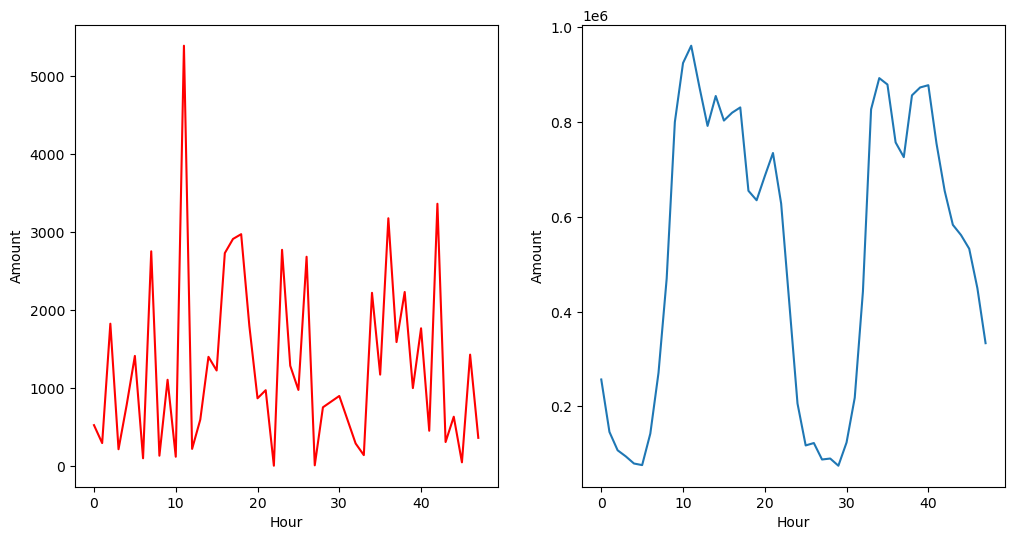

In [15]:
# Sum of Transaction Amount over Hour by Class
df['Hour'] = df['Time'].apply(lambda x: np.floor(x/3600))
fig, (ax1,ax2) = plt.subplots(ncols=2, figsize=(12,6))
df_1 = df[df['Class'] == 1]
df_0 = df[df['Class'] == 0]


s = sns.lineplot(ax=ax1,data=df_1, x='Hour', y='Amount', color='Red', errorbar=None, estimator='sum')
s = sns.lineplot(ax=ax2,data=df_0, x='Hour', y='Amount', errorbar=None, estimator='sum')

plt.show()

## Scaling of Time and Amount

In [16]:
scale = StandardScaler()

df[["Time"]] = scale.fit_transform(df[["Time"]]) 
df[["Amount"]] = scale.fit_transform(df[["Amount"]]) 

## Training-Test Split
Split the dataset into training and test (80-20).

In [17]:
target = 'Class'

predictors = ['Time', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10',
       'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20',
       'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'Amount']

x = df.loc[:, predictors]
y = df.loc[:, target]

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=2024)

## SMOTE
To train a model on an imbalanced dataset, we can opt for oversampling or undersampling. In this case I have opted for oversampling because undersampling would cause a huge reduction in the size of our dataset for training. This is especially so since only 0.172% of our target is 1. However, it is worth noting that oversampling using SMOTE would make model training more computationally expensive. Overall, it is more rational to opt for a longer model training time as opposed to losing over 90% of our dataset. Hence, we do oversampling.

In [18]:
from imblearn.over_sampling import SMOTE
from collections import Counter

smote = SMOTE()
x_train_smote, y_train_smote = smote.fit_resample(x_train, y_train)
print('Resampled dataset shape %s' % Counter(y_train_smote))

Resampled dataset shape Counter({0: 227473, 1: 227473})


In [19]:
train_data = lgb.Dataset(x_train_smote, label = y_train_smote)

## Hyperparameter Tuning Grid

In [20]:
param_grid = {
    'num_leaves': [30, 50, 70],  
    'learning_rate': [0.01, 0.05],
    'feature_fraction': [0.8, 1.0]
}

## CV Folds

In [21]:
kf = KFold(n_splits=5, shuffle=True, random_state=2024)

## Model Training

In [24]:
# initialise our desired values
best_score = 0
best_params = {}
models = []
scores = []

# iterating over each permutation of our param_grid
# trains models using our 5-fold cv
for num_leaves in param_grid['num_leaves']:
    for learning_rate in param_grid['learning_rate']:
        for feature_fraction in param_grid['feature_fraction']:
            params = {
                'objective': 'binary',
                'metric': 'auc',
                'is_unbalance': 'true',
                'num_leaves': num_leaves,
                'learning_rate': learning_rate,
                'feature_fraction': feature_fraction,
                'verbose': -1
            }

            fold_scores = []
            for train_index, val_index in kf.split(x_train_smote):
                x_train_fold, x_val_fold = x_train_smote.iloc[train_index], x_train_smote.iloc[val_index]
                y_train_fold, y_val_fold = y_train_smote.iloc[train_index], y_train_smote.iloc[val_index]

                train_data = lgb.Dataset(x_train_fold, label=y_train_fold)
                val_data = lgb.Dataset(x_val_fold, label=y_val_fold)

                model = lgb.train(params,
                                  train_data,
                                  valid_sets=[val_data],
                                  num_boost_round=2000, 
                                  callbacks=[lgb.early_stopping(stopping_rounds=200),]
                                 )
                
                score = model.best_score['valid_0']['auc']
                fold_scores.append(score)

            avg_score = np.mean(fold_scores)
            scores.append(avg_score)
            models.append(model)

            # Update best score and best params
            if avg_score > best_score:
                best_score = avg_score
                best_params = params

# output the best parameters and their corresponding score
print(f"Best Model Parameters: {best_params}")
print(f"Best Model AUC: {best_score}")

# use the best parameters to re-train the model on the full training set
best_model = lgb.train(best_params,
                       lgb.Dataset(x_train_smote, label=y_train_smote),
                       num_boost_round=2000,
                       valid_sets=[lgb.Dataset(x_train_smote, label=y_train_smote)],
                       callbacks=[lgb.early_stopping(stopping_rounds=200),])

Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[1926]	valid_0's auc: 1
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[1998]	valid_0's auc: 0.99999
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[1998]	valid_0's auc: 0.999982
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[2000]	valid_0's auc: 0.999996
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[2000]	valid_0's auc: 0.999988
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[1990]	valid_0's auc: 1
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[1987]	valid_0's auc: 0.999989
Training until validation sc

In [33]:
# save our model as pickle

import pickle

with open('model.pkl', 'wb') as file:
    pickle.dump(best_model, file)

In [22]:
# loading saved model

with open('model.pkl', 'rb') as file:
    best_model = pickle.load(file)

## Making Predictions

In [23]:
y_pred = best_model.predict(x_test)

## Scoring Metric: AUPRC
Area Under Curve of the Precision-Recall Curve is the proposed scoring metric.

In [27]:
precision, recall, _ = precision_recall_curve(y_test, y_pred)

# Calculate the AUC for the Precision-Recall Curve
auprc = auc(recall, precision)

print(f"Test AUPRC: {round(auprc,3)}")

Test AUPRC: 0.816


## Visualising our PR Curve

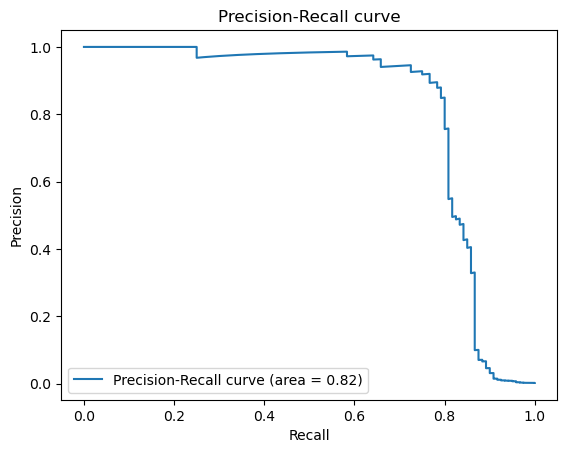

In [28]:
# Plotting
plt.figure()
plt.plot(recall, precision, label='Precision-Recall curve (area = %0.2f)' % auprc)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall curve')
plt.legend(loc="best")
plt.show()

## Confusion Matrix

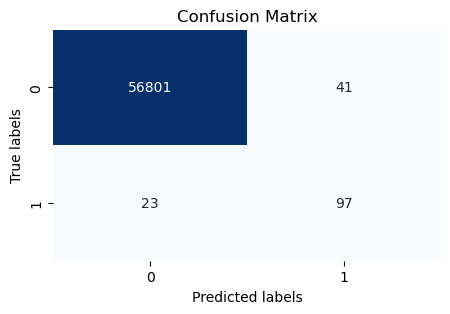

In [29]:
threshold = 0.5 
predictions = [1 if prob > threshold else 0 for prob in y_pred]

cm = confusion_matrix(y_test, predictions)

plt.figure(figsize=(5, 3))
sns.heatmap(cm, annot=True, fmt='g', cmap='Blues', cbar=False)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()

## Scoring Metric 2: Precision (TPR)
Extracting our TPR from the Confusion Matrix.

Given our highly imbalanced dataset, precision would be an ideal metric to evaluate model performance. i.e Given that a transaction is fraudulent, how often does our model correctly predict it as such? This gives us a better idea of how well our model is able to capture fraudulent transactions.

In [30]:
precision = cm[1][1]/(cm[1][1]+cm[1][0])
print('Precision:', round(precision,3))

Precision: 0.808


## Scoring Metric 3: Specificity (TNR)
True Negative Rate measures how often a negative prediction is indeed negative.

Ideally, we do not want to falsely accuse an honest customer of a fraudulent transaction. As such, specificity, which measures how often an honest transaction is actually honest, is crucial.

In [31]:
specificity = cm[0][0]/(cm[0][0]+cm[0][1])
print('Specificity:', round(specificity,3))

Specificity: 0.999


## Feature Importance
Here, we plot out the top 10 most important features in predicting whether a transaction is fraudulent. This would serve as a valuable business insight.

In [32]:
importances = best_model.feature_importance()
feature_names = best_model.feature_name()

In [33]:
feature_importance_df = pd.DataFrame({
    'Feature Name': feature_names,
    'Importance': importances
})
feature_importance_df.sort_values(by='Importance', ascending=False, inplace=True)

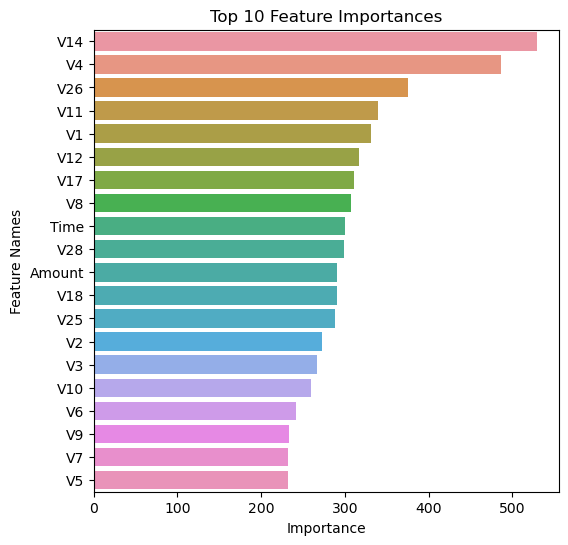

In [34]:
plt.figure(figsize=(6, 6))
sns.barplot(x='Importance', y='Feature Name', data=feature_importance_df.head(20))
plt.title('Top 10 Feature Importances')
plt.xlabel('Importance')
plt.ylabel('Feature Names')
plt.show()

## Conclusion

For our credit card fraud detection model, we achieved an AUPRC value of 0.816.

An AUPRC value of 0.808 indicates that our model maintains a high level of precision and recall across various thresholds. This means the model is effective at correctly identifying fraudulent transactions while minimising false positives. In the context of credit card fraud detection, AUPRC values typically range between 0.6 to 0.9 for effective models. A value of 0.816 positions our model within the upper range of this spectrum, signifying strong performance. This performance metric is particularly significant for operational deployment, where minimising false positives and maximising the detection of true fraud cases are critical.

Knowing the feature importances, even with anonymised names, is valuable for the organisation as it highlights which features significantly impact model performance. This information allows data scientists to optimise key features and reduce model complexity by eliminating low-importance features. It also guides strategic decision-making by focusing efforts on influential areas, improving data quality where it matters most, and ensures ongoing model stability.